In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import misc
from scipy.stats import norm, lognorm

We model stock price as a stochastic variable with drift $\mu$ and vol $\sigma$ such that:
\begin{equation}
    S_1 = S_0(1 + \mu dt + \sigma \sqrt{t}dw)
\end{equation}

For small time-scales and volatility, we can use lognormal returns as an approximation.

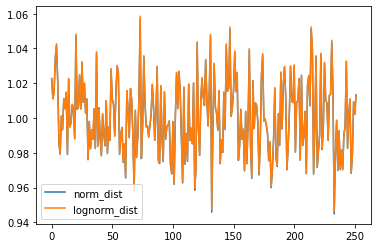

In [2]:
# Simulate daily returns for 1 year
drift = 0.02
vol = 0.3
step_size = 1/252

rn = np.random.rand(252)
norm1 = norm.ppf(rn, loc=drift * step_size, scale=vol * np.sqrt(step_size)) + 1
plt.plot(norm1, label='norm_dist')

lognorm1 = lognorm.ppf(rn, vol * np.sqrt(step_size), loc=0, scale=np.exp(drift * step_size))
plt.plot(lognorm1, label='lognorm_dist')
plt.legend()
plt.show()

Estimate the error of the lognormal approximation by simulating the returns after 1 year:

In [3]:
# normal distribution
f = 1 + drift + vol * np.random.normal(0, 1, size=10000000)
print(f'mean return after 1 year: {np.mean(f) - 1}')
print(f'drift: {drift}')

mean return after 1 year: 0.02017692628440848
drift: 0.02


In [4]:
# lognormal distribution
f = lognorm.ppf(np.random.rand(10000000), s=vol, loc=0, scale=np.exp(drift))
print(f'mean return after 1 year: {np.mean(f) - 1}')
print(f'drift + 0.5 * vol^2: {0.5 * vol ** 2 + drift}')

mean return after 1 year: 0.06701291186609515
drift + 0.5 * vol^2: 0.065


Difference between normal and lognormal distributions is $0.5\text{vol}^2$.

We note that the expectation of lognormal distribution with mean $\mu$ and standard deviation $\sigma$ is $e^{\mu + \frac{\sigma ^ 2}{2}}$.

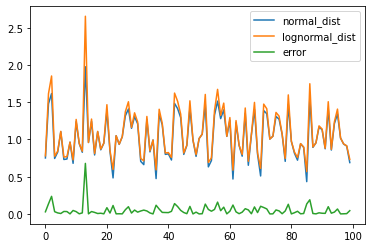

In [5]:
# simulate error for each calculation
n = []
lgn = []
for i in range(100):
    w = np.random.rand()
    n.append(1 + drift + vol * norm.ppf(w, loc=0, scale=1))
    lgn.append(lognorm.ppf(w, s=vol, loc=0, scale=np.exp(drift)))

n = np.array(n)
lgn = np.array(lgn)

plt.plot(n, label='normal_dist')
plt.plot(lgn, label='lognormal_dist')
plt.plot((lgn - n), label='error')
plt.legend()
plt.show()

Errors are random and small compared to correct returns

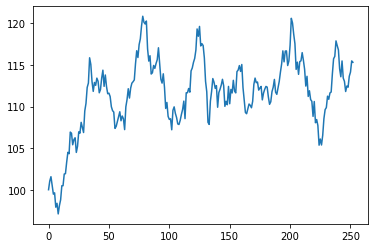

In [6]:
drift = 0.01
vol = 0.2
initial_stock_price = 100

def generate_stochastic_stock_price(drift, vol, initial_price, num_steps, step_size):
    '''
    drift, vol, step_size to be quoted as annualised values
    e.g. step_size = (1 / 252) for daily stock price
    '''
    w = np.random.normal(0, 1, size=num_steps)
    returns = 1 + drift * step_size + vol * np.sqrt(step_size) * w
    returns = np.insert(returns, 0, 1)
    prices = initial_price * np.cumprod(returns)
    return prices

plt.plot(generate_stochastic_stock_price(drift, vol, initial_stock_price, 252, 1 / 252))


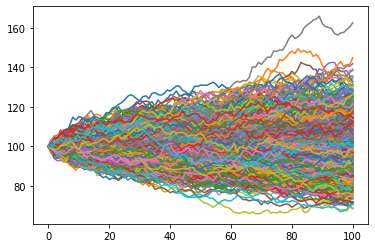

In [7]:
price_series_arr = np.array([generate_stochastic_stock_price(drift, vol, initial_stock_price, 100, 1/252) for f in range(1000)])
for f in price_series_arr:
    plt.plot(f)
plt.show()

Simulate an option contract

average payoff: 7.534076903144457


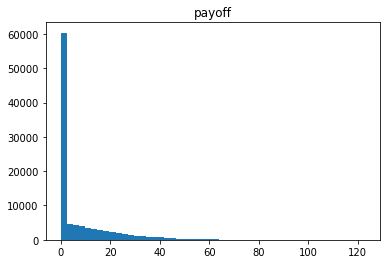

In [8]:
num_trials = 100000
# stock parameters
drift = 0
vol = 0.2
initial_stock_price = 100
step_size = 1/252

# call option parameters
strike = 101
dte = 252
payoffs = []

price_series_arr = np.array([generate_stochastic_stock_price(drift, vol, initial_stock_price, dte, step_size) for f in range(num_trials)])
for i in range(num_trials):
    final_price = price_series_arr[i][-1]
    payoffs.append(max(0, final_price - strike))
payoffs = np.array(payoffs)

print(f'average payoff: {np.mean(payoffs)}')

plt.hist(payoffs, bins=50)
plt.title('payoff')
plt.show()

The price of the option should be equal to the expected payoff. We can compare to the simulated price to the black scholes model.

In [9]:
from utils import bsm

print(f'BSM call price: {bsm.get_call_price(strike, dte, initial_stock_price, vol, div_yield=0, rf_rate=0)}')

BSM call price: 7.515267758969337


Suppose we buy a call option and hedge it every day by shorting stock:

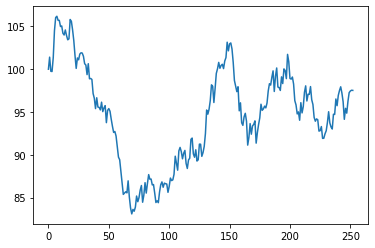

In [10]:
# generate price series
price_series = generate_stochastic_stock_price(drift, vol, initial_stock_price, dte, step_size)
plt.plot(price_series)
plt.show()

c:\Users\alexr\Quantitative_Finance_Modelling\utils\bsm.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(curr_price / strike) \


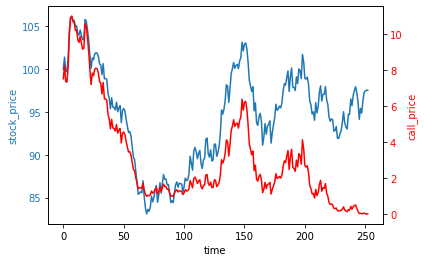

In [11]:
# simulate option price
dte_arr = np.arange(dte, -1, -1)
call_price_arr = np.array([bsm.get_call_price(strike, dte_arr[i], price_series[i], vol) for i in range(dte + 1)])

fig, ax1 = plt.subplots()
t = np.arange(0, dte + 1, 1)

color = 'C0'
ax1.set_xlabel('time')
ax1.set_ylabel('stock_price', color=color)
ax1.plot(t, price_series, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'red'
ax2 = ax1.twinx()
ax2.set_ylabel('call_price', color=color)
ax2.plot(t, call_price_arr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

c:\Users\alexr\Quantitative_Finance_Modelling\utils\bsm.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(curr_price / strike) \


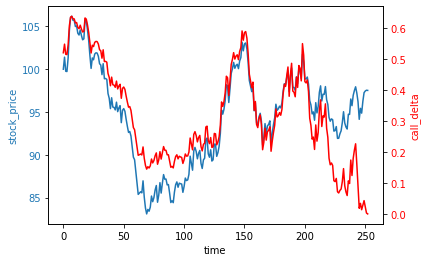

In [12]:
# simulate call delta
call_delta_arr = np.array([bsm.get_call_delta(strike, dte_arr[i], price_series[i], vol) for i in range(dte + 1)])

t = np.arange(0, dte + 1, 1)
fig, ax1 = plt.subplots()

color = 'C0'
ax1.set_xlabel('time')
ax1.set_ylabel('stock_price', color=color)
ax1.plot(t, price_series, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'red'
ax2 = ax1.twinx()
ax2.set_ylabel('call_delta', color=color)
ax2.plot(t, call_delta_arr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

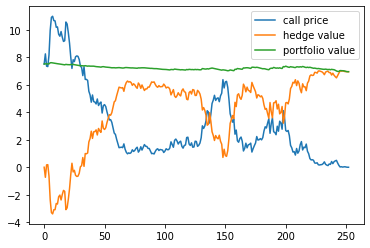

In [13]:
# hedge call by shorting shares equivalent to call delta

hedge_profit_arr = []
for i in range(dte):
    # open short hedge today and close the next day
    hgp = -call_delta_arr[i] * (price_series[i + 1] - price_series[i])
    hedge_profit_arr.append(hgp)
hedge_profit_arr = np.array(hedge_profit_arr)

# value of the hedge = cumulative sum of hedge profits
hedge_value_arr = np.cumsum(hedge_profit_arr)
hedge_value_arr = np.insert(hedge_value_arr, 0, 0)

# portfolio value = sum of call option value and hedge value
port_value_arr = call_price_arr + hedge_value_arr

plt.plot(call_price_arr, label='call price')
plt.plot(hedge_value_arr, label='hedge value')
plt.plot(port_value_arr, label='portfolio value')
plt.legend()
plt.show()


We note there is some change in the portfolio value, even though we hedged perfectly according the black scholes model. Since we have created a risk-free portfolio by hedging, we should make the risk-free rate (0 in this case). However, there is clearly some change in portfolio value

In [14]:
print(f'total P&L on portfolio: {port_value_arr[-1] - port_value_arr[0]}')

total P&L on portfolio: -0.5611899646616365


We can run this simulation multiple times and observe the total portfolio P&L.

c:\Users\alexr\Quantitative_Finance_Modelling\utils\bsm.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(curr_price / strike) \


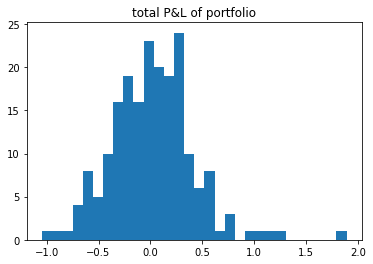

average P&L: 0.02071470996992917


In [15]:
# simulate multiple times:
def simulate_hedged_port_profit(num_trials=200):
    dte_arr = np.arange(dte, -1, -1)
    port_profit_arr = []
    for i in range(num_trials):
        # generate price series
        price_series = generate_stochastic_stock_price(drift, vol, initial_stock_price, dte, step_size)
        call_delta_arr = np.array([bsm.get_call_delta(strike, dte_arr[i], price_series[i], vol) for i in range(dte + 1)])
        # compute hedge profit
        hedge_profit_arr = np.array([-call_delta_arr[i] * (price_series[i + 1] - price_series[i]) for i in range(dte)])
        # value of the hedge = cumulative sum of hedge profits
        hedge_profit = np.sum(hedge_profit_arr)
        port_profit = hedge_profit + max(0, price_series[-1] - strike) - bsm.get_call_price(strike, dte, initial_stock_price, vol)
        port_profit_arr.append(port_profit)
    return np.array(port_profit_arr)

port_profit_arr = simulate_hedged_port_profit()
plt.hist(port_profit_arr, bins=30)
plt.title('total P&L of portfolio')
plt.show()

print(f'average P&L: {np.mean(port_profit_arr)}')
    

The profit/error is small and seems to follow a normal distribution.

We suspect the discrepancy to be due to truncation error. Black-scholes assumes continuous hedging, but we are hedging once per day. If this hypothesis is correct, if we hedge less frequently, e.g. once per 2 days, we should get a bigger error. Since the error depends on the path of the stock price, which is random, the error should be random as well. Therefore, the error should be centered about 0 and have increasing standard deviation as the hedge period increases. 

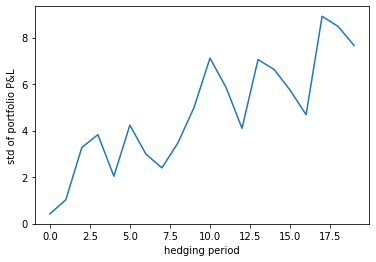

In [16]:
def simulate_hedged_port_profit(hedge_period=1, num_trials=1000):
    dte_arr = np.arange(dte, -1, -1)
    port_profit_arr = []
    for i in range(num_trials):
        # generate price series
        price_series = generate_stochastic_stock_price(drift, vol, initial_stock_price, dte, step_size)
        call_delta_arr = np.array([bsm.get_call_delta(strike, dte_arr[i], price_series[i], vol) for i in range(dte + 1)])
        j = 0
        hedge_profit = 0
        while j + hedge_period <= dte:
            hgp = -call_delta_arr[j] * (price_series[j + hedge_period] - price_series[j])
            hedge_profit += hgp
            j += hedge_period
        port_profit = hedge_profit + max(0, price_series[-1] - strike) - bsm.get_call_price(strike, dte, initial_stock_price, vol)
        port_profit_arr.append(port_profit)
    return np.array(port_profit_arr)

port_profit_by_hedge_period = []
for i in range(1, 100, 5):
    port_profit_arr = simulate_hedged_port_profit(hedge_period=i)
    port_profit_by_hedge_period.append(np.std(port_profit_arr))
plt.plot(port_profit_by_hedge_period)
plt.ylabel('std of portfolio P&L')
plt.xlabel('hedging period')
plt.show()

Consider the case where we are making an implied vol trade with a call option. 

The market price of the call indicates an implied vol of $v_1 = 0.2$, but we predict the volatility of the stock price over the lifetime of the option to be $v_2 = 30$.

We believe that the option is underpriced compared to expectation of the final payoffs. Therefore, we should buy the call option and hold it till expiration.

average profit: 1.3650391899985401


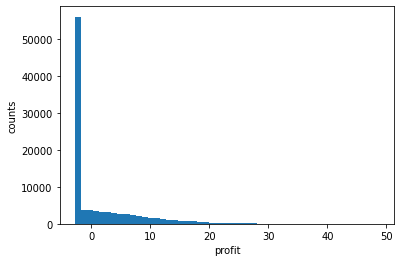

In [53]:
v1 = 0.2
v2 = 0.3
strike = 100
dte = 30
init_stock_price = 100
drift = 0
step_size = 1/252


init_call_price = bsm.get_call_price(strike, dte, init_stock_price, v1)

payoff_arr = []
for i in range(100000):
    # assume that our model is correct
    price_series = generate_stochastic_stock_price(drift, v2, init_stock_price, dte, step_size)
    payoff = max(price_series[-1] - strike, 0)
    payoff_arr.append(payoff)
payoff_arr = np.array(payoff_arr)

# profit is the payoff - initial price we paid for call option
profit_arr = payoff_arr - init_call_price

print(f'average profit: {np.mean(profit_arr)}')
plt.hist(profit_arr, bins=50)
plt.xlabel('profit')
plt.ylabel('counts')
plt.show()


The performance and risk-profile of this strategy is not ideal.

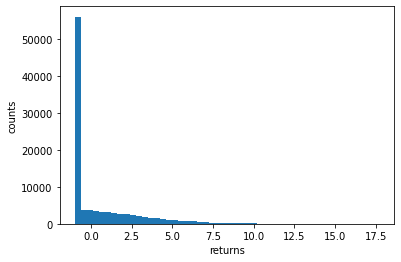

mean return: 0.4959419717076382
return std: 2.32533380758279


In [54]:
returns_arr = np.array([profit_arr[i] / init_call_price for i in range(len(profit_arr))])
plt.hist(returns_arr, bins=50)
plt.xlabel('returns')
plt.ylabel('counts')
plt.show()

print(f'mean return: {np.mean(returns_arr)}')
print(f'return std: {np.std(returns_arr)}')

This strategy presents highly skewed and highly volatile returns.

We can get a better risk profile by delta hedging. We can purchase the call and short the stock according to the delta of the call each day.

 However, we need to choose between using the model volatility $v_2$ or the implied volatility $v_1$ for hedging.

We simulate 4 cases:
- actual 20 vol, hedged to 20 vol
- actual 30 vol, hedged to 20 vol
- actual 20 vol, hedged to 30 vol
- actual 30 vol, hedged to 30 vol

In [64]:
# simulate 20 vol, hedge to 20 and 30 vol
init_call_price = bsm.get_call_price(strike, dte, init_stock_price, v1)
dte_arr = np.arange(dte, -1, -1)

payoff_arr = []
v1_hedge_profit_arr = []
v2_hedge_profit_arr = []
real_vol_arr = []
final_price_arr = []
for i in range(10000):
    # generate price series
    price_series = generate_stochastic_stock_price(drift, v1, init_stock_price, dte, step_size)
    # realised volatility
    real_vol = np.std(np.diff(price_series) / price_series[:-1])
    real_vol_arr.append(real_vol)
    # final price
    final_price_arr.append(price_series[-1])
    # generate call delta according to implied vol and model vol
    v1_call_delta_arr = np.array([bsm.get_call_delta(strike, dte_arr[i], price_series[i], v1) for i in range(dte + 1)])
    v2_call_delta_arr = np.array([bsm.get_call_delta(strike, dte_arr[i], price_series[i], v2) for i in range(dte + 1)])
    # hedge with stock
    v1_hedge_profit = np.sum([-v1_call_delta_arr[i] * (price_series[i + 1] - price_series[i]) for i in range(dte)])
    v2_hedge_profit = np.sum([-v2_call_delta_arr[i] * (price_series[i + 1] - price_series[i]) for i in range(dte)])
    v1_hedge_profit_arr.append(v1_hedge_profit)
    v2_hedge_profit_arr.append(v2_hedge_profit)
    # calculate payoff
    payoff = max(price_series[-1] - strike, 0)
    payoff_arr.append(payoff)

# convert to np array
payoff_arr = np.array(payoff_arr)
v1_hedge_profit_arr = np.array(v1_hedge_profit_arr)
v2_hedge_profit_arr = np.array(v2_hedge_profit_arr)
vol20_real_vol = np.array(real_vol_arr)
vol20_final_price = np.array(final_price_arr)

# profit is the call price we received for selling the call - the eventual payoff
profit_arr = payoff_arr - init_call_price

# adding back the hedge profits
vol20_hedge30_profit = profit_arr + v1_hedge_profit_arr
vol20_hedge20_profit = profit_arr + v2_hedge_profit_arr

c:\Users\alexr\Quantitative_Finance_Modelling\utils\bsm.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(curr_price / strike) \


In [65]:
# simulate 30 vol, hedge to 20 vol and 30 vol
init_call_price = bsm.get_call_price(strike, dte, init_stock_price, v1)
dte_arr = np.arange(dte, -1, -1)

payoff_arr = []
v1_hedge_profit_arr = []
v2_hedge_profit_arr = []
real_vol_arr = []
final_price_arr = []
for i in range(10000):
    # generate price series
    price_series = generate_stochastic_stock_price(drift, v2, init_stock_price, dte, step_size)
    # realised volatility
    real_vol = np.std(np.diff(price_series) / price_series[:-1])
    real_vol_arr.append(real_vol)
    # final price
    final_price_arr.append(price_series[-1])
    # generate call delta according to implied vol and model vol
    v1_call_delta_arr = np.array([bsm.get_call_delta(strike, dte_arr[i], price_series[i], v1) for i in range(dte + 1)])
    v2_call_delta_arr = np.array([bsm.get_call_delta(strike, dte_arr[i], price_series[i], v2) for i in range(dte + 1)])
    # hedge with stock
    v1_hedge_profit = np.sum([-v1_call_delta_arr[i] * (price_series[i + 1] - price_series[i]) for i in range(dte)])
    v2_hedge_profit = np.sum([-v2_call_delta_arr[i] * (price_series[i + 1] - price_series[i]) for i in range(dte)])
    v1_hedge_profit_arr.append(v1_hedge_profit)
    v2_hedge_profit_arr.append(v2_hedge_profit)
    # calculate payoff
    payoff = max(price_series[-1] - strike, 0)
    payoff_arr.append(payoff)

# convert to np array
payoff_arr = np.array(payoff_arr)
v1_hedge_profit_arr = np.array(v1_hedge_profit_arr)
v2_hedge_profit_arr = np.array(v2_hedge_profit_arr)
vol30_real_vol = np.array(real_vol_arr)
vol30_final_price = np.array(final_price_arr)

# profit = payoff - initial call price
profit_arr = payoff_arr - init_call_price

# adding back the hedge profits
vol30_hedge30_profit = profit_arr + v1_hedge_profit_arr
vol30_hedge20_profit = profit_arr + v2_hedge_profit_arr

The results of the simulations are presented below:

Note that the call has implied 20 vol

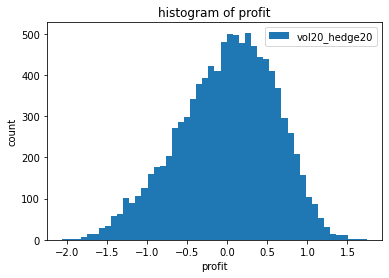

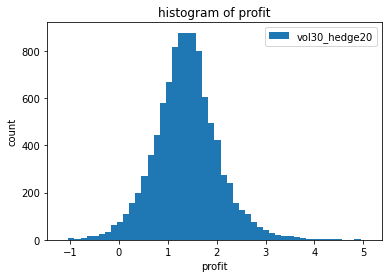

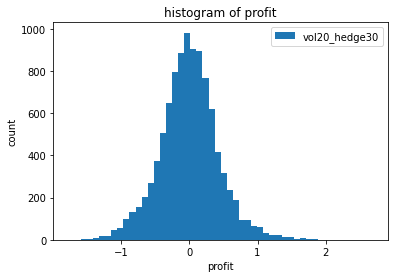

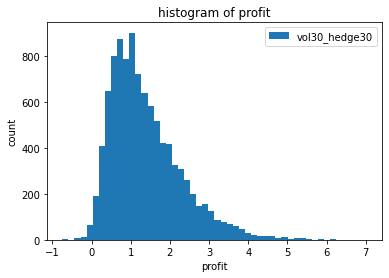

In [66]:
plt.hist(vol20_hedge20_profit, bins=50, label='vol20_hedge20')
plt.xlabel('profit')
plt.ylabel('count')
plt.title('histogram of profit')
plt.legend()
plt.show()

plt.hist(vol30_hedge20_profit, bins=50, label='vol30_hedge20')
plt.xlabel('profit')
plt.ylabel('count')
plt.title('histogram of profit')
plt.legend()
plt.show()

plt.hist(vol20_hedge30_profit, bins=50, label='vol20_hedge30')
plt.xlabel('profit')
plt.ylabel('count')
plt.title('histogram of profit')
plt.legend()
plt.show()

plt.hist(vol30_hedge30_profit, bins=50, label='vol30_hedge30')
plt.xlabel('profit')
plt.ylabel('count')
plt.title('histogram of profit')
plt.legend()
plt.show()

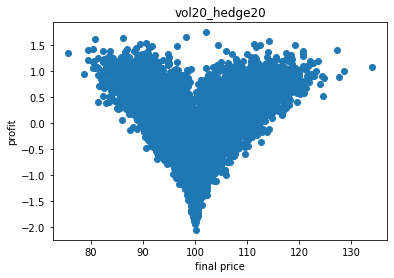

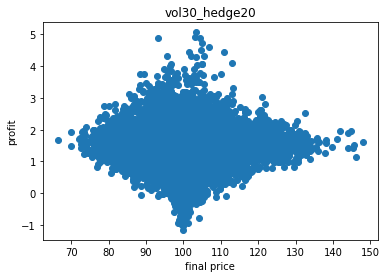

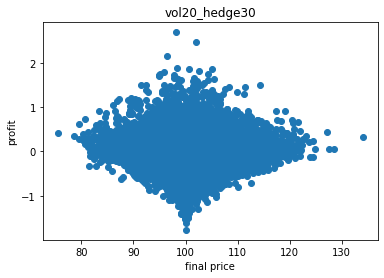

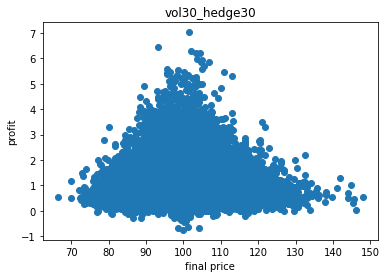

In [68]:
plt.scatter(vol20_final_price, vol20_hedge20_profit)
plt.xlabel('final price')
plt.ylabel('profit')
plt.title('vol20_hedge20')
plt.show()

plt.scatter(vol30_final_price, vol30_hedge20_profit)
plt.xlabel('final price')
plt.ylabel('profit')
plt.title('vol30_hedge20')
plt.show()

plt.scatter(vol20_final_price, vol20_hedge30_profit)
plt.xlabel('final price')
plt.ylabel('profit')
plt.title('vol20_hedge30')
plt.show()

plt.scatter(vol30_final_price, vol30_hedge30_profit)
plt.xlabel('final price')
plt.ylabel('profit')
plt.title('vol30_hedge30')
plt.show()

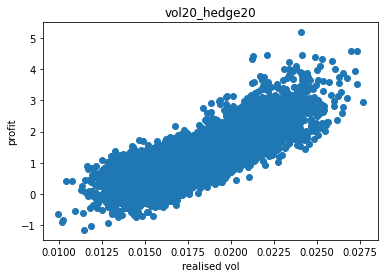

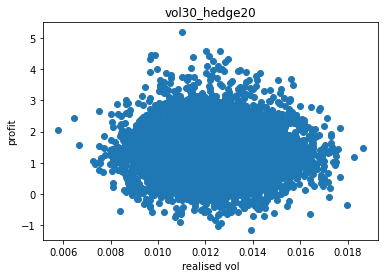

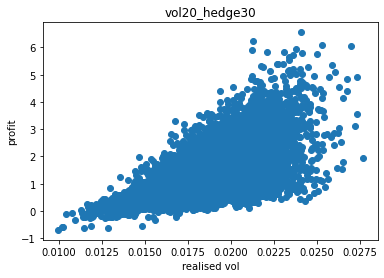

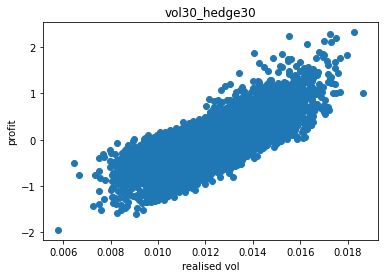

In [63]:
plt.scatter(vol20_real_vol, vol20_hedge20_profit)
plt.xlabel('realised vol')
plt.ylabel('profit')
plt.title('vol20_hedge20')
plt.show()

plt.scatter(vol30_real_vol, vol20_hedge20_profit)
plt.xlabel('realised vol')
plt.ylabel('profit')
plt.title('vol30_hedge20')
plt.show()

plt.scatter(vol20_real_vol, vol20_hedge30_profit)
plt.xlabel('realised vol')
plt.ylabel('profit')
plt.title('vol20_hedge30')
plt.show()

plt.scatter(vol30_real_vol, vol30_hedge30_profit)
plt.xlabel('realised vol')
plt.ylabel('profit')
plt.title('vol30_hedge30')
plt.show()